# Zillow Regression Project: Estimating Home Value

In [98]:
#import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


# https://seaborn.pydata.org/tutorial/color_palettes.html
# https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html

# set seaborn color palette
sns.color_palette("viridis")
pal = sns.set_palette('viridis')

# import models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import explained_variance_score

from sklearn.linear_model import TweedieRegressor

import sklearn.feature_selection as feat_select
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder, normalize, StandardScaler

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

#import custom functions
import acquire
#import prepare
#import explore
import wrangle


# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import SelectKBest, f_regression, RFE


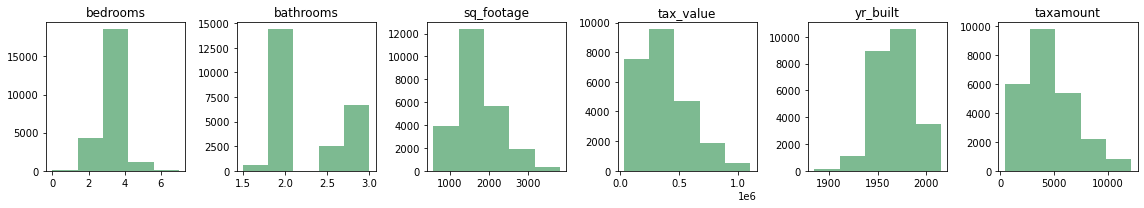

In [2]:
df = wrangle.wrangle_zillow()

In [3]:
df.head()

bedrooms  bathrooms  sq_footage  tax_value  yr_built  taxamount    fips  \
0       3.0        2.0      1772.0   418763.0    1978.0    4464.42  6111.0   
1       3.0        2.0      1819.0   478430.0    1981.0    5515.94  6111.0   
3       2.0        2.0      1503.0   171687.0    1933.0    2287.55  6037.0   
4       4.0        2.0      1604.0   498347.0    1950.0    6089.82  6037.0   
5       3.0        3.0      2384.0   549917.0    1937.0    6679.55  6037.0   

   propertylandusetypeid        propertylandusedesc  tax_rate       county  
0                  261.0  Single Family Residential  0.010661      Ventura  
1                  261.0  Single Family Residential  0.011529      Ventura  
3                  261.0  Single Family Residential  0.013324  Los Angeles  
4                  261.0  Single Family Residential  0.012220  Los Angeles  
5                  261.0  Single Family Residential  0.012146  Los Angeles

In [4]:
df.shape

(24200, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24200 entries, 0 to 37545
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bedrooms               24200 non-null  float64
 1   bathrooms              24200 non-null  float64
 2   sq_footage             24200 non-null  float64
 3   tax_value              24200 non-null  float64
 4   yr_built               24200 non-null  float64
 5   taxamount              24200 non-null  float64
 6   fips                   24200 non-null  float64
 7   propertylandusetypeid  24200 non-null  float64
 8   propertylandusedesc    24200 non-null  object 
 9   tax_rate               24200 non-null  float64
 10  county                 24200 non-null  object 
dtypes: float64(9), object(2)
memory usage: 2.2+ MB


In [6]:
df.isna().sum()

bedrooms                 0
bathrooms                0
sq_footage               0
tax_value                0
yr_built                 0
taxamount                0
fips                     0
propertylandusetypeid    0
propertylandusedesc      0
tax_rate                 0
county                   0
dtype: int64

In [7]:
df[df.duplicated()]

Empty DataFrame
Columns: [bedrooms, bathrooms, sq_footage, tax_value, yr_built, taxamount, fips, propertylandusetypeid, propertylandusedesc, tax_rate, county]
Index: []

In [8]:
print("Mean of bedrooms:",df.bedrooms.mean())
print("Mean of bathrooms:", df.bathrooms.mean())
print("Mean of square footage:",df.sq_footage.mean())
print("Mean of tax value : ", df.tax_value.mean())
print("Mean of yr built:", df.yr_built.mean())
print("Mean of tax amount:", df.taxamount.mean())

Mean of bedrooms: 3.2044214876033057
Mean of bathrooms: 2.318264462809917
Mean of square footage: 1721.784090909091
Mean of tax value :  373053.87880165287
Mean of yr built: 1967.4255785123967
Mean of tax amount: 4511.10015082643


In [9]:
df.apply(wrangle.minMax)

bedrooms  bathrooms  sq_footage  tax_value  yr_built  taxamount    fips  \
min       0.0        1.5       576.0    32433.0    1885.0     407.57  6037.0   
max       7.0        3.0      3804.0  1101116.0    2015.0   12137.26  6111.0   

     propertylandusetypeid propertylandusedesc  tax_rate       county  
min                  261.0        Cluster Home  0.008329  Los Angeles  
max                  266.0           Townhouse  0.016787      Ventura

array([[<AxesSubplot:title={'center':'fips'}>]], dtype=object)

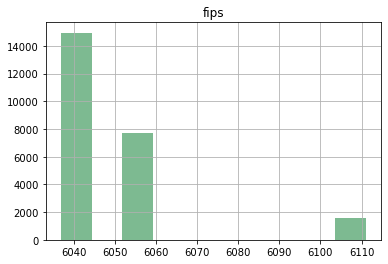

In [10]:
df.hist('fips')

In [11]:
df.fips.value_counts()

6037.0    14949
6059.0     7682
6111.0     1569
Name: fips, dtype: int64

array([[<AxesSubplot:title={'center':'propertylandusetypeid'}>]],
      dtype=object)

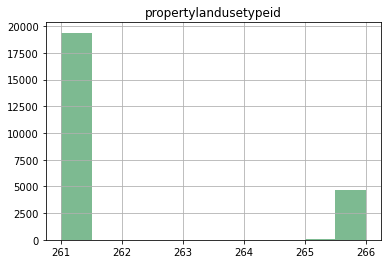

In [12]:
df.hist('propertylandusetypeid')

In [13]:
df.propertylandusetypeid.value_counts()

261.0    19391
266.0     4686
265.0       96
263.0       25
264.0        2
Name: propertylandusetypeid, dtype: int64

In [14]:
df.bathrooms.value_counts()

2.0    14362
3.0     6728
2.5     2529
1.5      581
Name: bathrooms, dtype: int64

In [15]:
df.bedrooms.value_counts()

3.0    11568
4.0     6978
2.0     4268
5.0     1113
1.0      159
6.0       99
7.0       11
0.0        4
Name: bedrooms, dtype: int64

In [16]:
df.sq_footage.mean()

1721.784090909091

In [17]:
df.sq_footage.min()

576.0

In [18]:
df.sq_footage.max()

3804.0

In [30]:
df.shape

(24200, 11)

## Getting State & County Info for Each Property and Tax Rates for Each County

Zach lost the email that told us where these properties were located. Ugh, Zach :-/. Because property taxes are assessed at the county level, we would like to know what states and counties these are located in.

We'd also like to know the distribution of tax rates for each county.

The data should have the tax amounts and tax value of the home, so it shouldn't be too hard to calculate. Please include in your report to us the distribution of tax rates for each county so that we can see how much they vary within the properties in the county and the rates the bulk of the properties sit around.

Note that this is separate from the model you will build, because if you use tax amount in your model, you would be using a future data point to predict a future data point, and that is cheating! In other words, for prediction purposes, we won't know tax amount until we know tax value.

In [33]:
#Create the tax rate for each property and add it to the dataframe


In [34]:
#Created a new column identifying the county for each property and add it to the dataframe 
df.head()

bedrooms  bathrooms  sq_footage  tax_value  yr_built  taxamount    fips  \
0       3.0        2.0      1772.0   418763.0    1978.0    4464.42  6111.0   
1       3.0        2.0      1819.0   478430.0    1981.0    5515.94  6111.0   
3       2.0        2.0      1503.0   171687.0    1933.0    2287.55  6037.0   
4       4.0        2.0      1604.0   498347.0    1950.0    6089.82  6037.0   
5       3.0        3.0      2384.0   549917.0    1937.0    6679.55  6037.0   

   propertylandusetypeid        propertylandusedesc  tax_rate       county  
0                  261.0  Single Family Residential  0.010661      Ventura  
1                  261.0  Single Family Residential  0.011529      Ventura  
3                  261.0  Single Family Residential  0.013324  Los Angeles  
4                  261.0  Single Family Residential  0.012220  Los Angeles  
5                  261.0  Single Family Residential  0.012146  Los Angeles

In [35]:
df.fips.value_counts()

6037.0    14949
6059.0     7682
6111.0     1569
Name: fips, dtype: int64

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24200 entries, 0 to 37545
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bedrooms               24200 non-null  float64
 1   bathrooms              24200 non-null  float64
 2   sq_footage             24200 non-null  float64
 3   tax_value              24200 non-null  float64
 4   yr_built               24200 non-null  float64
 5   taxamount              24200 non-null  float64
 6   fips                   24200 non-null  float64
 7   propertylandusetypeid  24200 non-null  float64
 8   propertylandusedesc    24200 non-null  object 
 9   tax_rate               24200 non-null  float64
 10  county                 24200 non-null  object 
dtypes: float64(9), object(2)
memory usage: 2.2+ MB


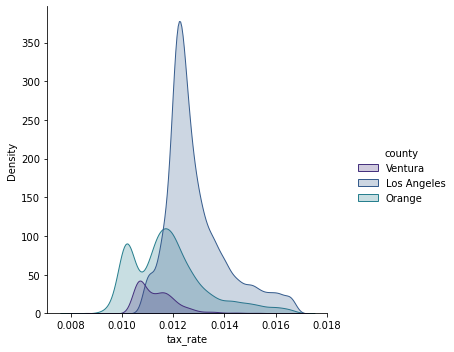

In [37]:
#Plotting distribution of tax rate by county

sns.displot(df, x='tax_rate', hue='county', kind='kde', fill=True)
plt.show()

In [25]:
df.tax_rate.max()

0.01678727023250226

In [26]:
df.tax_rate.min()

0.008328859424163674

In [27]:
df.tax_rate.mean()

0.012447484808495625

In [32]:
df.groupby('county').tax_rate.mean()

county
Los Angeles    0.012863
Orange         0.011846
Ventura        0.011436
Name: tax_rate, dtype: float64

# Split Data

In [28]:
#Split data into train, validate and test datasets to prepare for exploration
train, validate, test = wrangle.split_data(df)
train.shape, validate.shape, test.shape

((13552, 11), (5808, 11), (4840, 11))

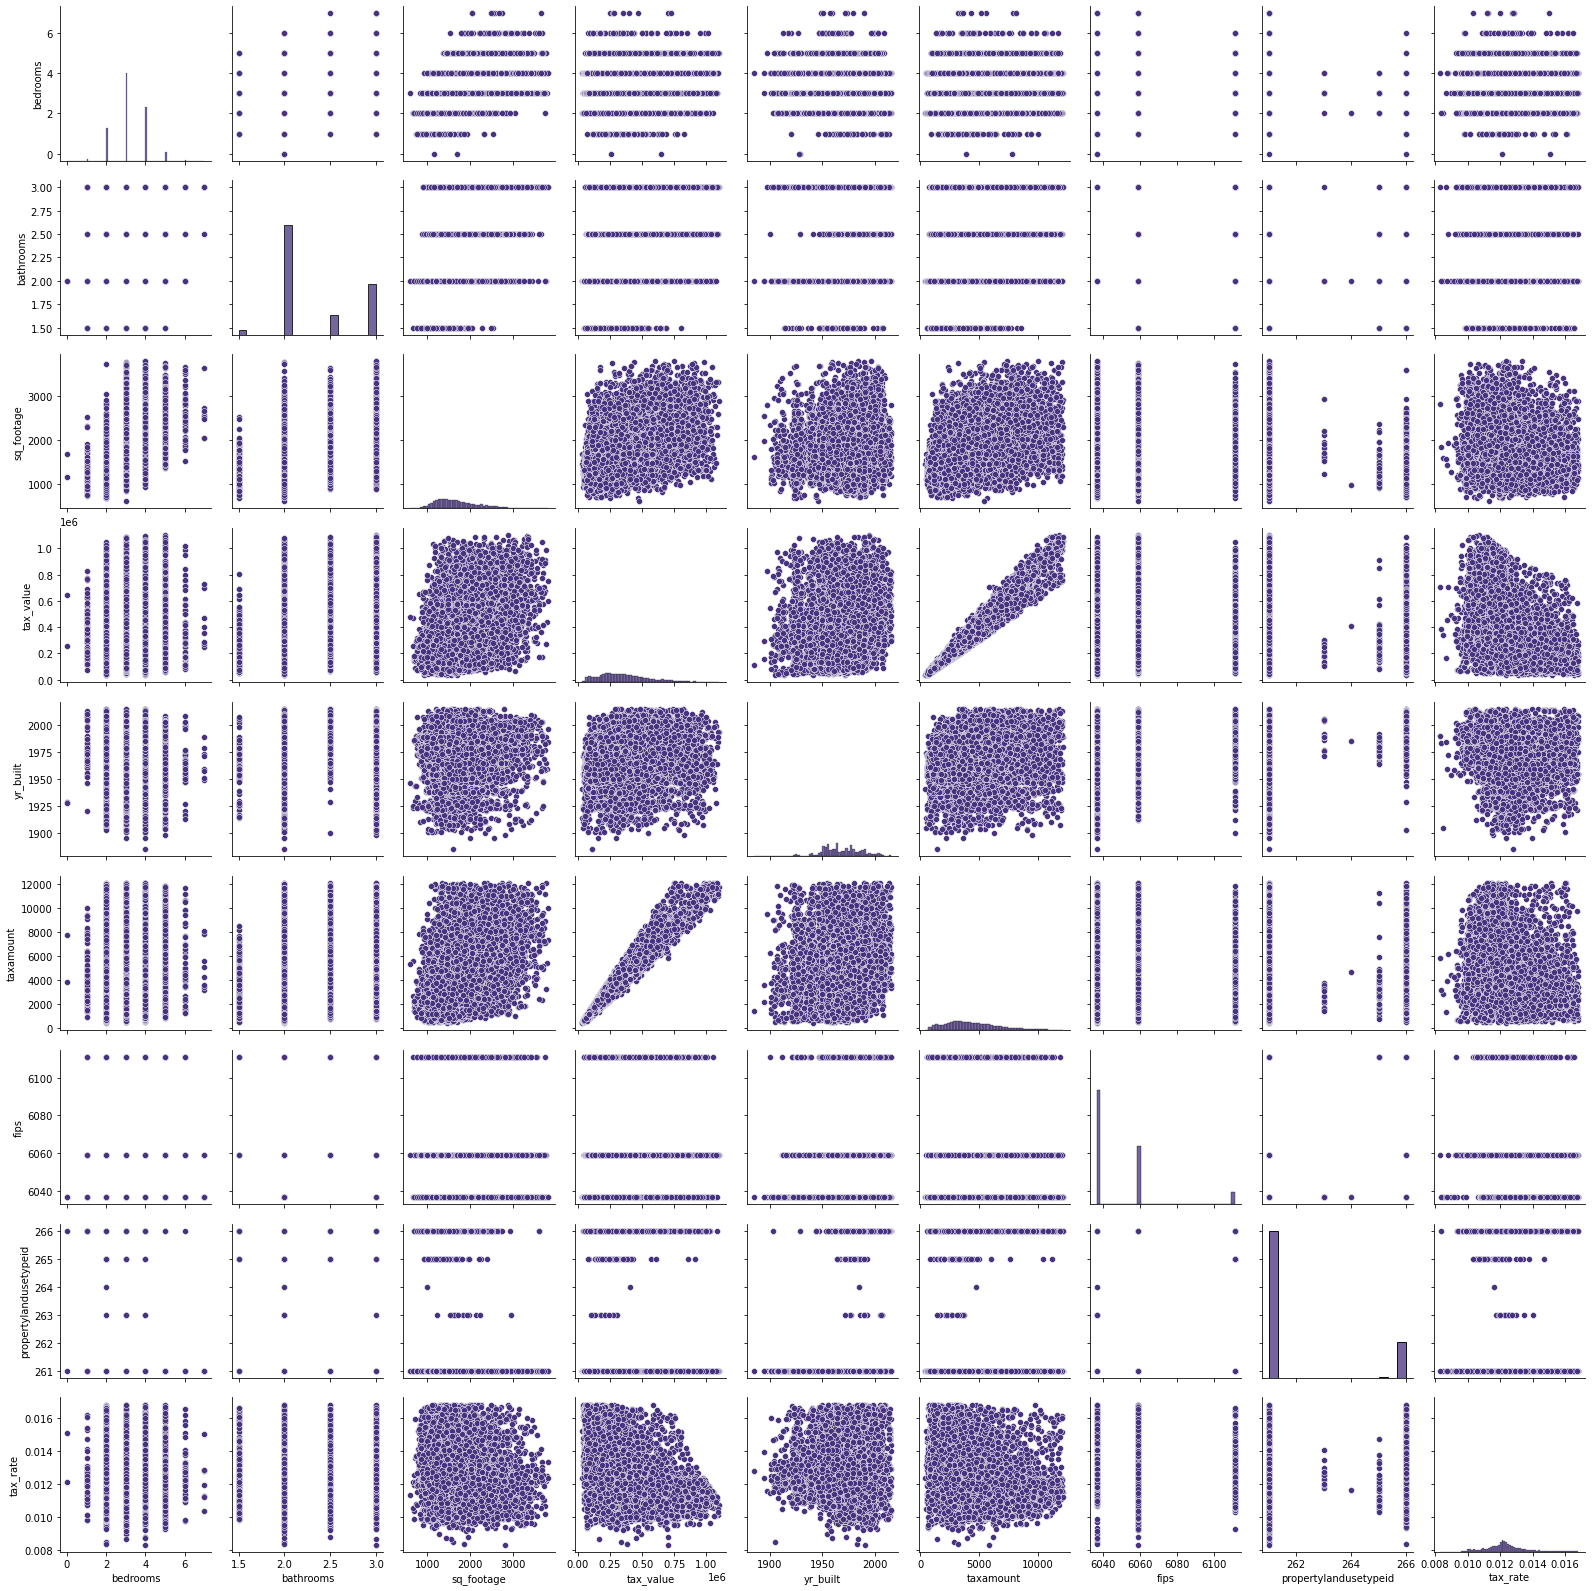

In [29]:
sns.pairplot(train)

In [38]:
train.groupby('bedrooms').bathrooms.mean()

bedrooms
0.0    2.000000
1.0    2.024390
2.0    2.181837
3.0    2.240658
4.0    2.462009
5.0    2.745902
6.0    2.833333
7.0    2.937500
Name: bathrooms, dtype: float64

In [42]:
X_train = train.drop(columns=['tax_value','propertylandusedesc', 'tax_rate', 'county']) 
X_validate = validate.drop(columns=['tax_value','propertylandusedesc','tax_rate','county'])
X_test = test.drop(columns=['tax_value','propertylandusedesc','tax_rate','county'])

y_train = train.tax_value
y_validate = validate.tax_value
y_test = test.tax_value

In [43]:
X_train.shape, X_validate.shape, X_test.shape, y_train.shape, y_validate.shape, y_test.shape

((13552, 7), (5808, 7), (4840, 7), (13552,), (5808,), (4840,))

In [44]:
X_train

bedrooms  bathrooms  sq_footage  yr_built  taxamount    fips  \
4012        2.0        2.0      1384.0    1940.0   10557.17  6037.0   
5946        3.0        2.0      1932.0    1960.0    4096.68  6037.0   
27404       2.0        3.0      1325.0    1976.0    3742.85  6037.0   
34138       5.0        3.0      2691.0    1953.0   10609.84  6037.0   
14592       2.0        2.0       795.0    1987.0    2555.38  6037.0   
...         ...        ...         ...       ...        ...     ...   
33069       5.0        3.0      2735.0    1950.0    4159.09  6037.0   
20477       2.0        2.0      1501.0    1955.0    1771.92  6037.0   
17126       2.0        2.0       955.0    1973.0    3734.86  6037.0   
37270       2.0        2.0       994.0    1979.0    3748.06  6059.0   
1495        3.0        2.0      1208.0    1979.0    1196.79  6037.0   

       propertylandusetypeid  
4012                   261.0  
5946                   261.0  
27404                  266.0  
34138                  261.0  
14592                  266.0  
...                      ...  
33069                  261.0  
20477                  261.0  
17126                  266.0  
37270                  266.0  
1495                   261.0  

[13552 rows x 7 columns]

In [46]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13552 entries, 4012 to 1495
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bedrooms               13552 non-null  float64
 1   bathrooms              13552 non-null  float64
 2   sq_footage             13552 non-null  float64
 3   yr_built               13552 non-null  float64
 4   taxamount              13552 non-null  float64
 5   fips                   13552 non-null  float64
 6   propertylandusetypeid  13552 non-null  float64
dtypes: float64(7)
memory usage: 847.0 KB


In [47]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validate = scaler.transform(X_validate)
X_test = scaler.transform(X_test)

In [48]:
X_train = pd.DataFrame(X_train, columns = ['bedrooms','bathrooms','sq_footage','yr_built','taxamount','fips','propertylandusetypeid',])
X_validate = pd.DataFrame(X_validate, columns = ['bedrooms','bathrooms','sq_footage','yr_built','taxamount','fips','propertylandusetypeid',])
X_test = pd.DataFrame(X_test, columns = ['bedrooms','bathrooms','sq_footage','yr_built','taxamount','fips','propertylandusetypeid',])

In [49]:
X_train

bedrooms  bathrooms  sq_footage  yr_built  taxamount      fips  \
0     -1.464755  -0.699890   -0.633440 -1.412727   2.555829 -0.609359   
1     -0.249328  -0.699890    0.400308 -0.383511  -0.179215 -0.609359   
2     -1.464755   1.496708   -0.744737  0.439862  -0.329009 -0.609359   
3      2.181527   1.496708    1.832086 -0.743736   2.578126 -0.609359   
4     -1.464755  -0.699890   -1.744530  1.005931  -0.831724 -0.609359   
...         ...        ...         ...       ...        ...       ...   
13547  2.181527   1.496708    1.915088 -0.898119  -0.152794 -0.609359   
13548 -1.464755  -0.699890   -0.412731 -0.640815  -1.163401 -0.609359   
13549 -1.464755  -0.699890   -1.442706  0.285480  -0.332392 -0.609359   
13550 -1.464755  -0.699890   -1.369136  0.594245  -0.326803  0.529580   
13551 -0.249328  -0.699890   -0.965446  0.594245  -1.406882 -0.609359   

       propertylandusetypeid  
0                  -0.499756  
1                  -0.499756  
2                   2.011254  
3                  -0.499756  
4                   2.011254  
...                      ...  
13547              -0.499756  
13548              -0.499756  
13549               2.011254  
13550               2.011254  
13551              -0.499756  

[13552 rows x 7 columns]

In [50]:
def plot_categorical_and_continuous_vars(categorical_vars, continuous_vars, df, descriptive=None):
    """
    This function that takes in a string name of a categorical variable, 
    a string name from a continuous variable and the df they live in and
    displays 4 different plots.
    """
    for categorical_var in categorical_vars:
        for continuous_var in continuous_vars:
            categorical_label = categorical_var
            continuous_label = continuous_var

            if descriptive:
                categorical_label = descriptive[categorical_var]
                continuous_label = descriptive[continuous_var]
                
            fig, axes = plt.subplots(figsize=(12,36), nrows=4,ncols=1)
            fig.suptitle(f'{continuous_label} by {categorical_label}', fontsize=18, y=1.02)

            sns.lineplot(ax=axes[0], x=categorical_var, y=continuous_var, data=df)
            axes[0].set_title('Line Plot', fontsize=14)
            axes[0].set_xlabel(categorical_label, fontsize=12)
            axes[0].set_ylabel(continuous_label, fontsize=12)
            
            sns.boxplot(ax=axes[1], x=categorical_var, y=continuous_var, data=df,\
                        color='blue')
            axes[1].set_title('Box-and-Whiskers Plot', fontsize=14)
            axes[1].set_xlabel(categorical_label, fontsize=12)
            axes[1].set_ylabel(continuous_label, fontsize=12)
            
            sns.swarmplot(ax=axes[2], x=categorical_var, y=continuous_var, data=df,\
                        palette='Blues')
            axes[2].set_title('Swarm Plot', fontsize=14)
            axes[2].set_xlabel(categorical_label, fontsize=12)
            axes[2].set_ylabel(continuous_label, fontsize=12)
            
            sns.barplot(ax=axes[3], x=categorical_var, y=continuous_var, data=df,\
                        palette='Purples')
            axes[3].set_title('Bar Plot', fontsize=14)
            axes[3].set_xlabel(categorical_label, fontsize=12)
            axes[3].set_ylabel(continuous_label, fontsize=12)
            
            plt.tight_layout()

            plt.show()

In [52]:
categorical_vars = ['bedrooms', 'bathrooms','fips', 'propertylandusetypeid']
continuous_vars = ['sq_footage', 'tax_value']

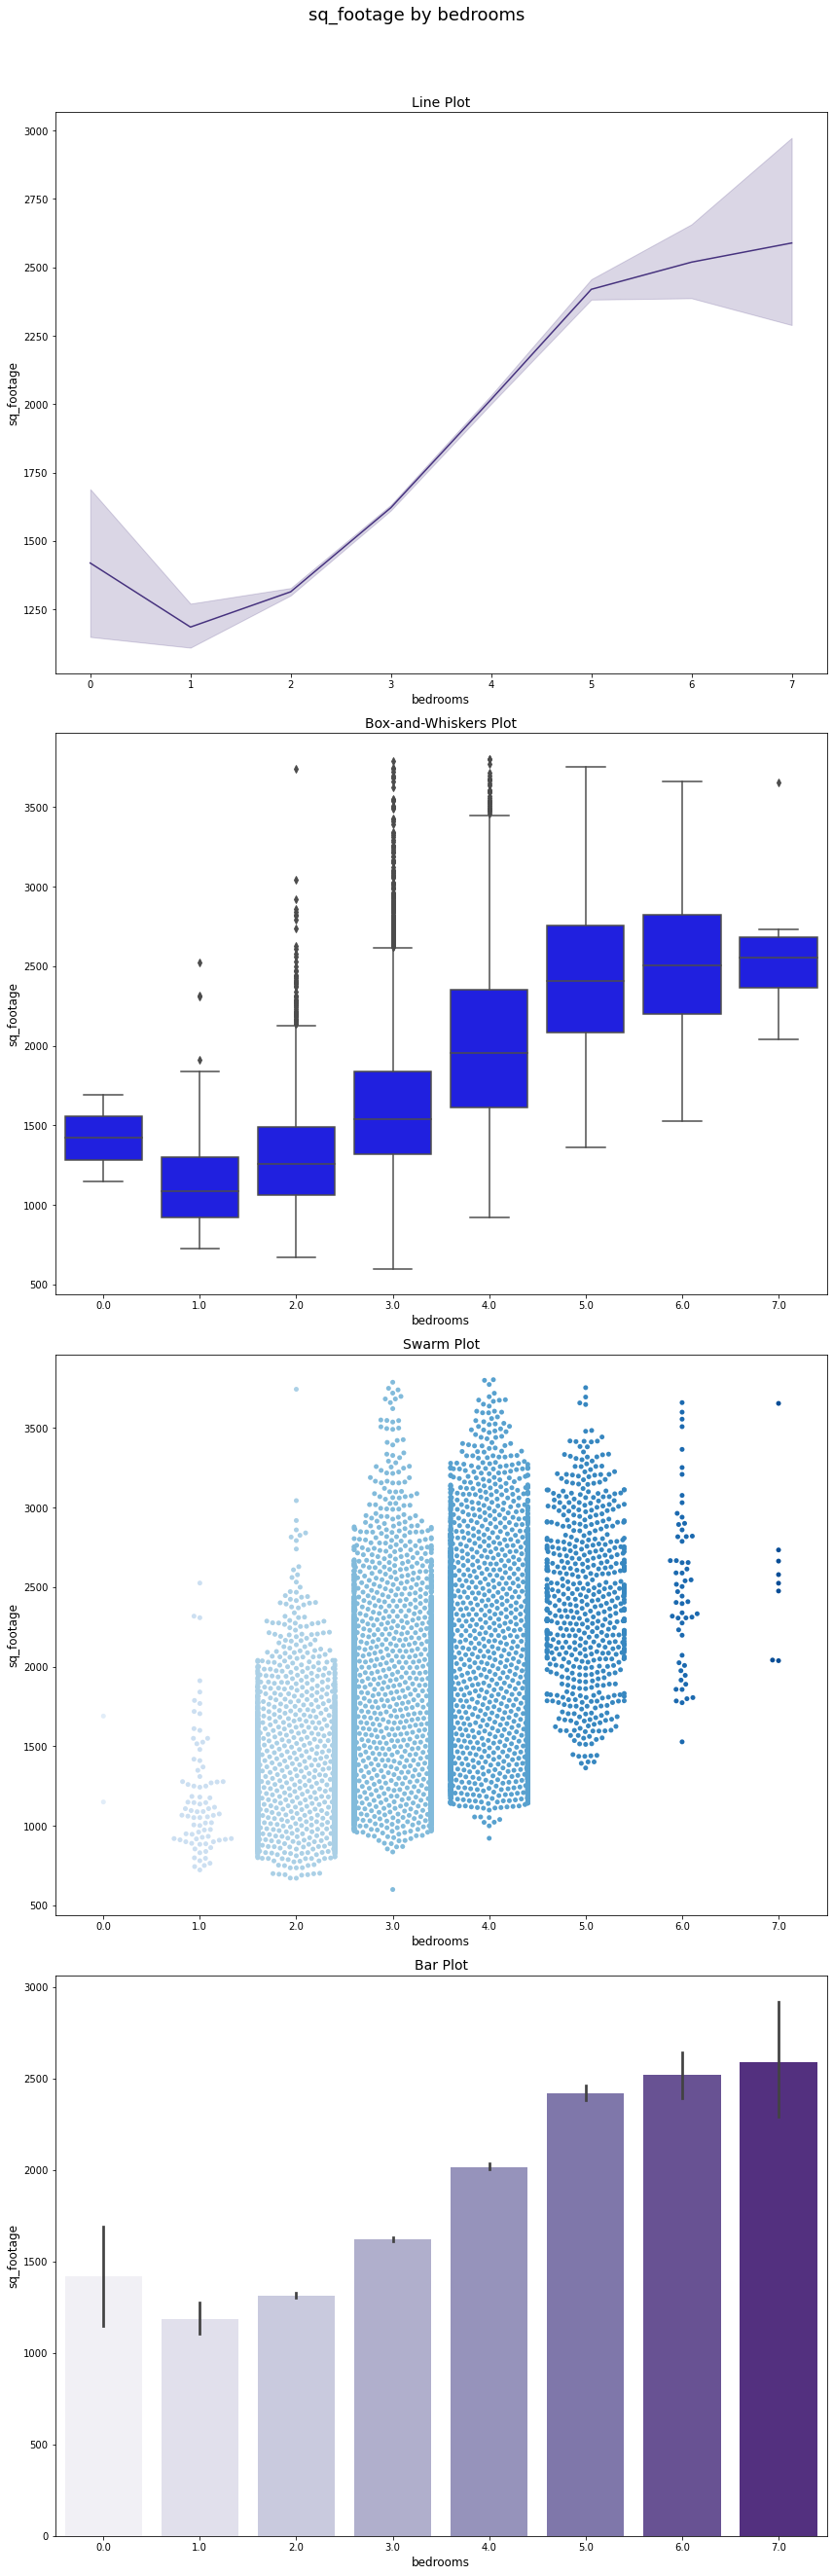

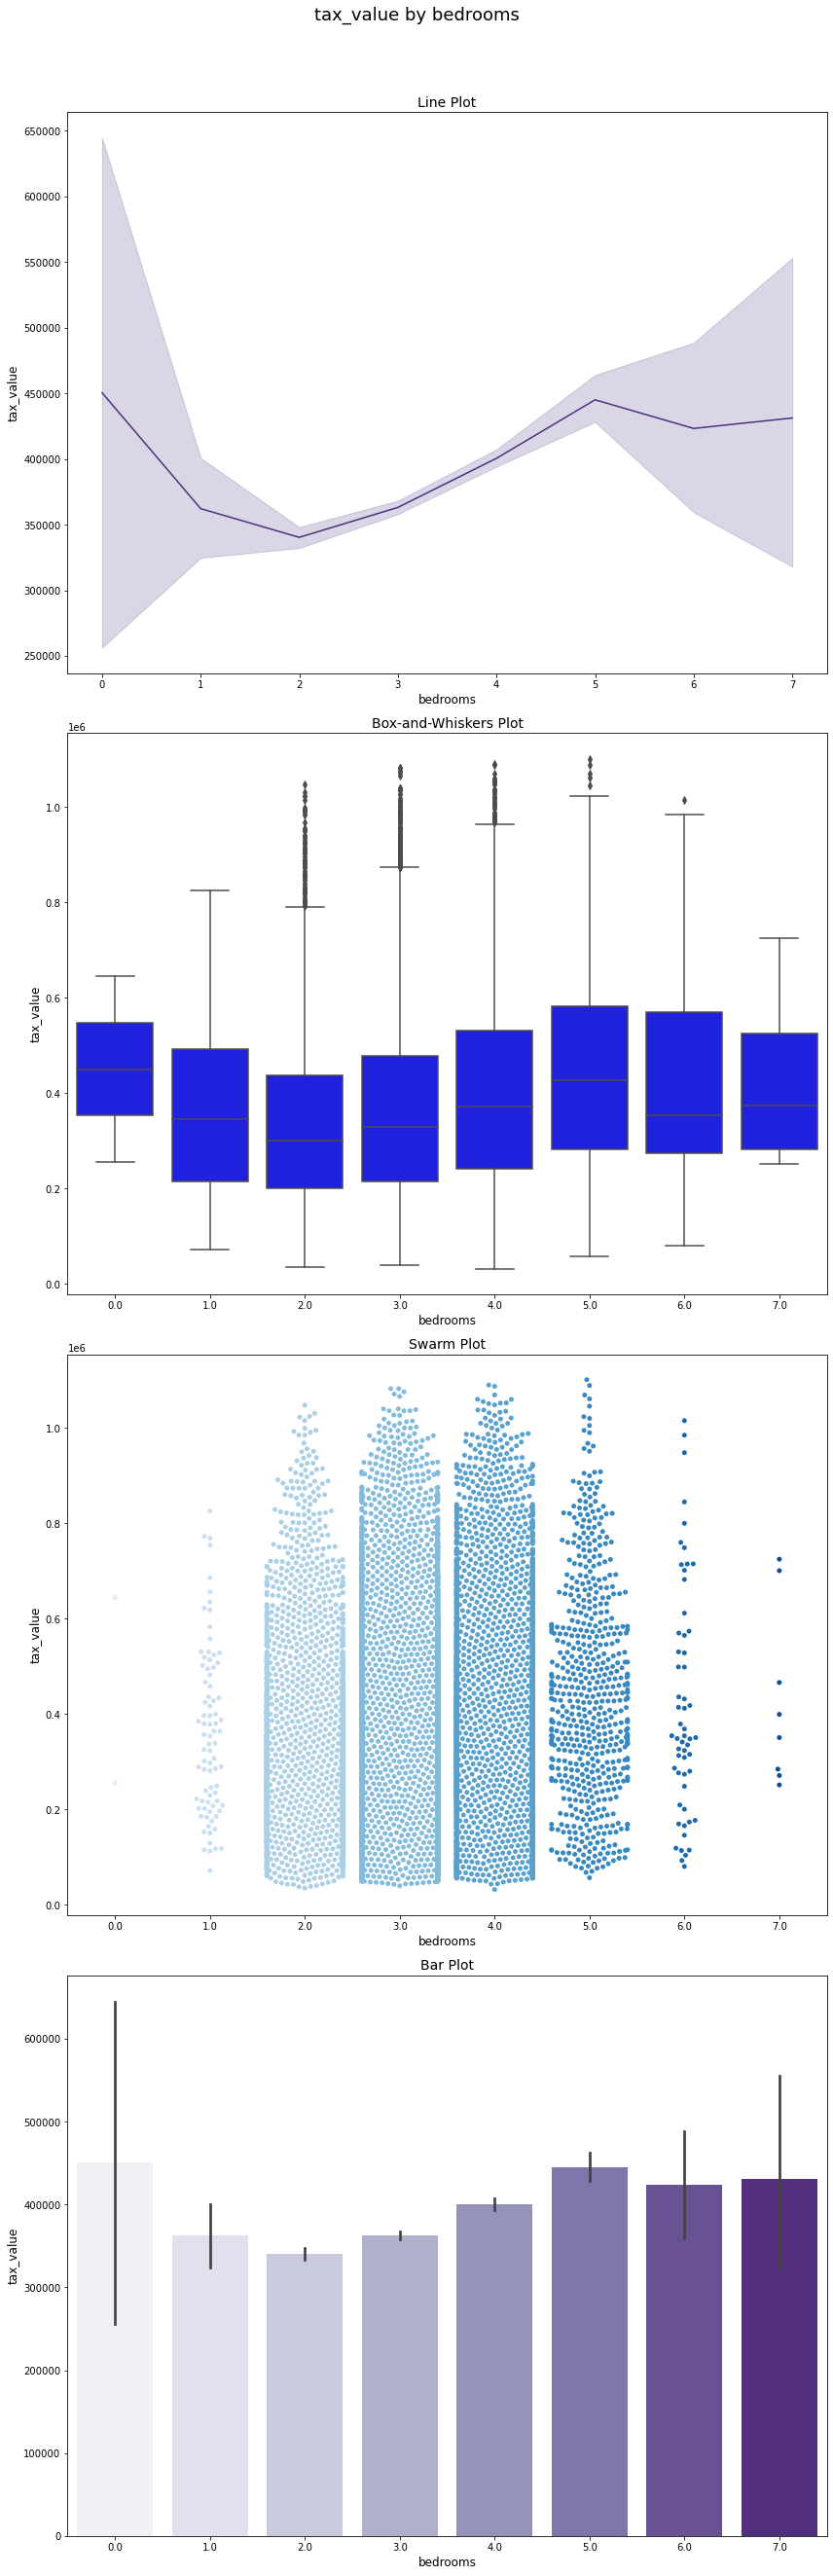

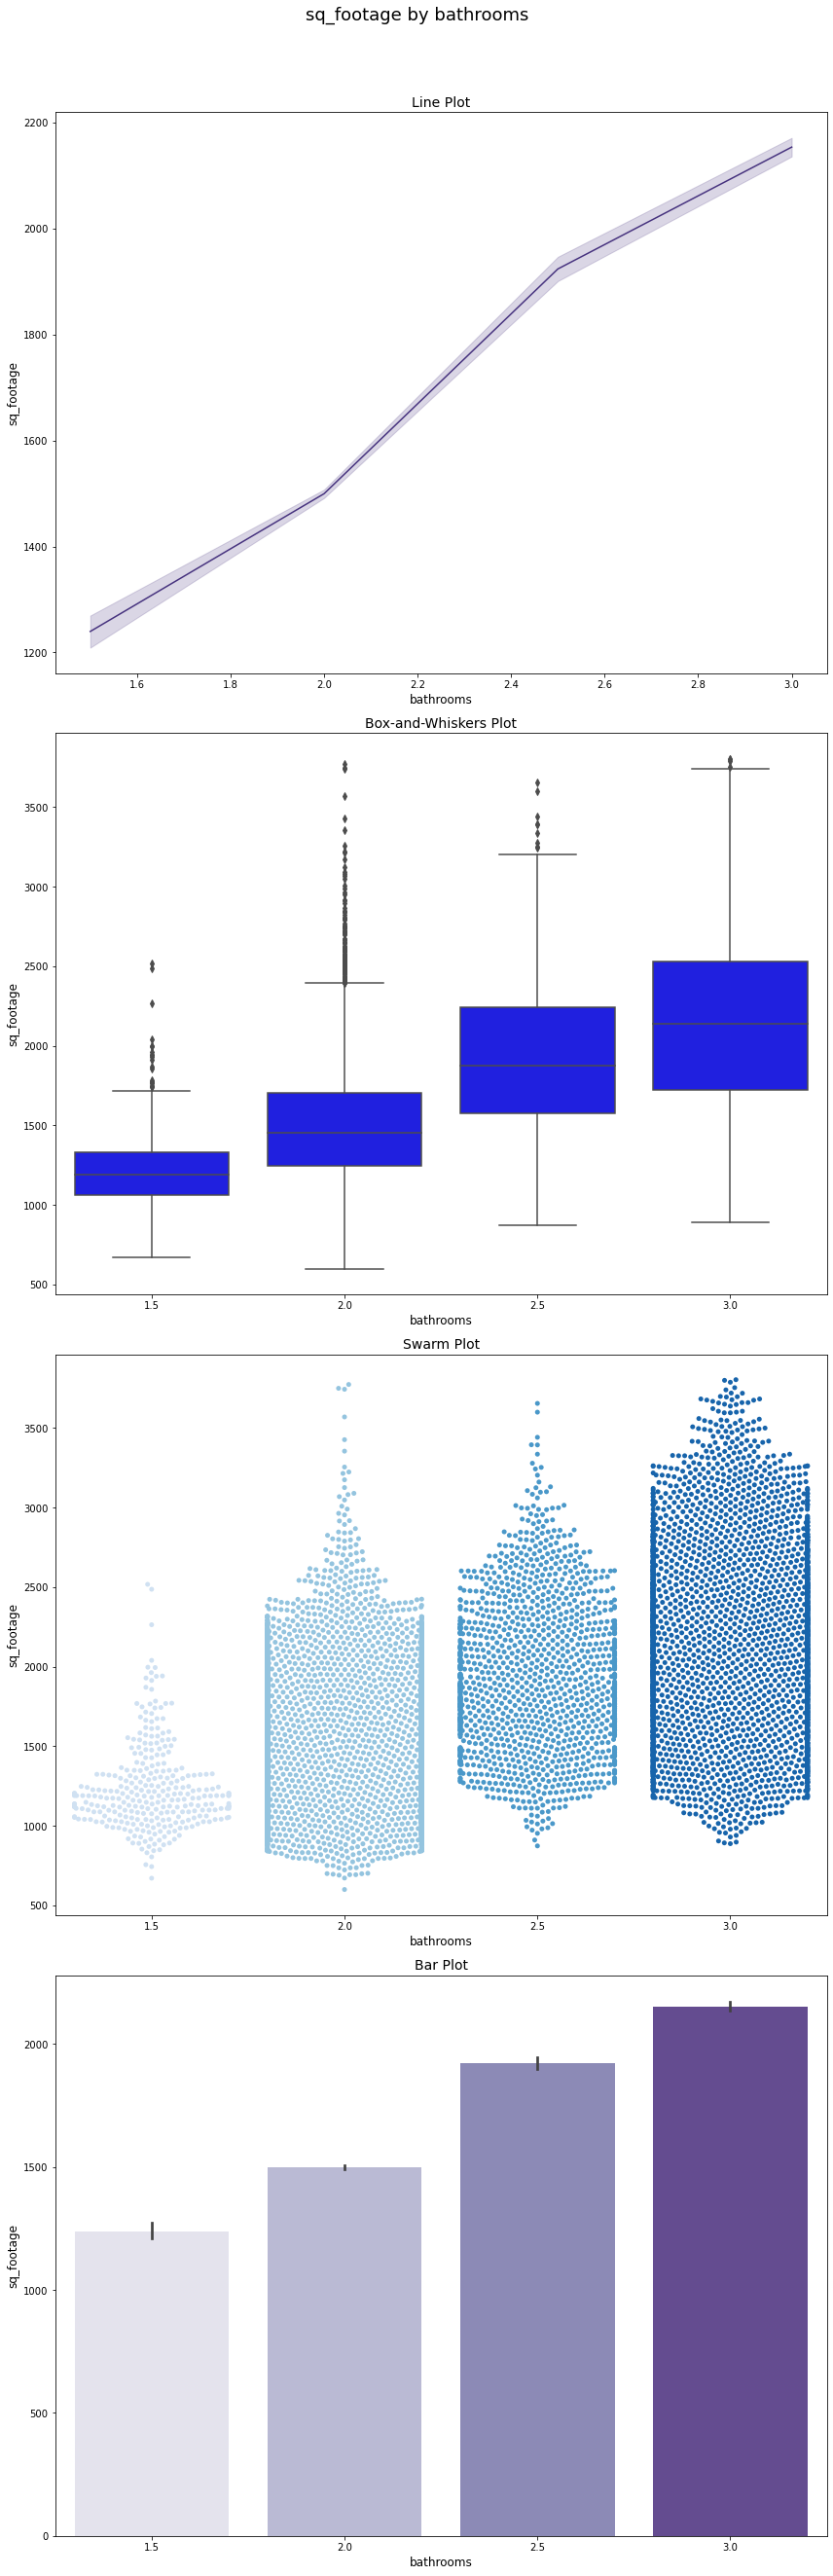

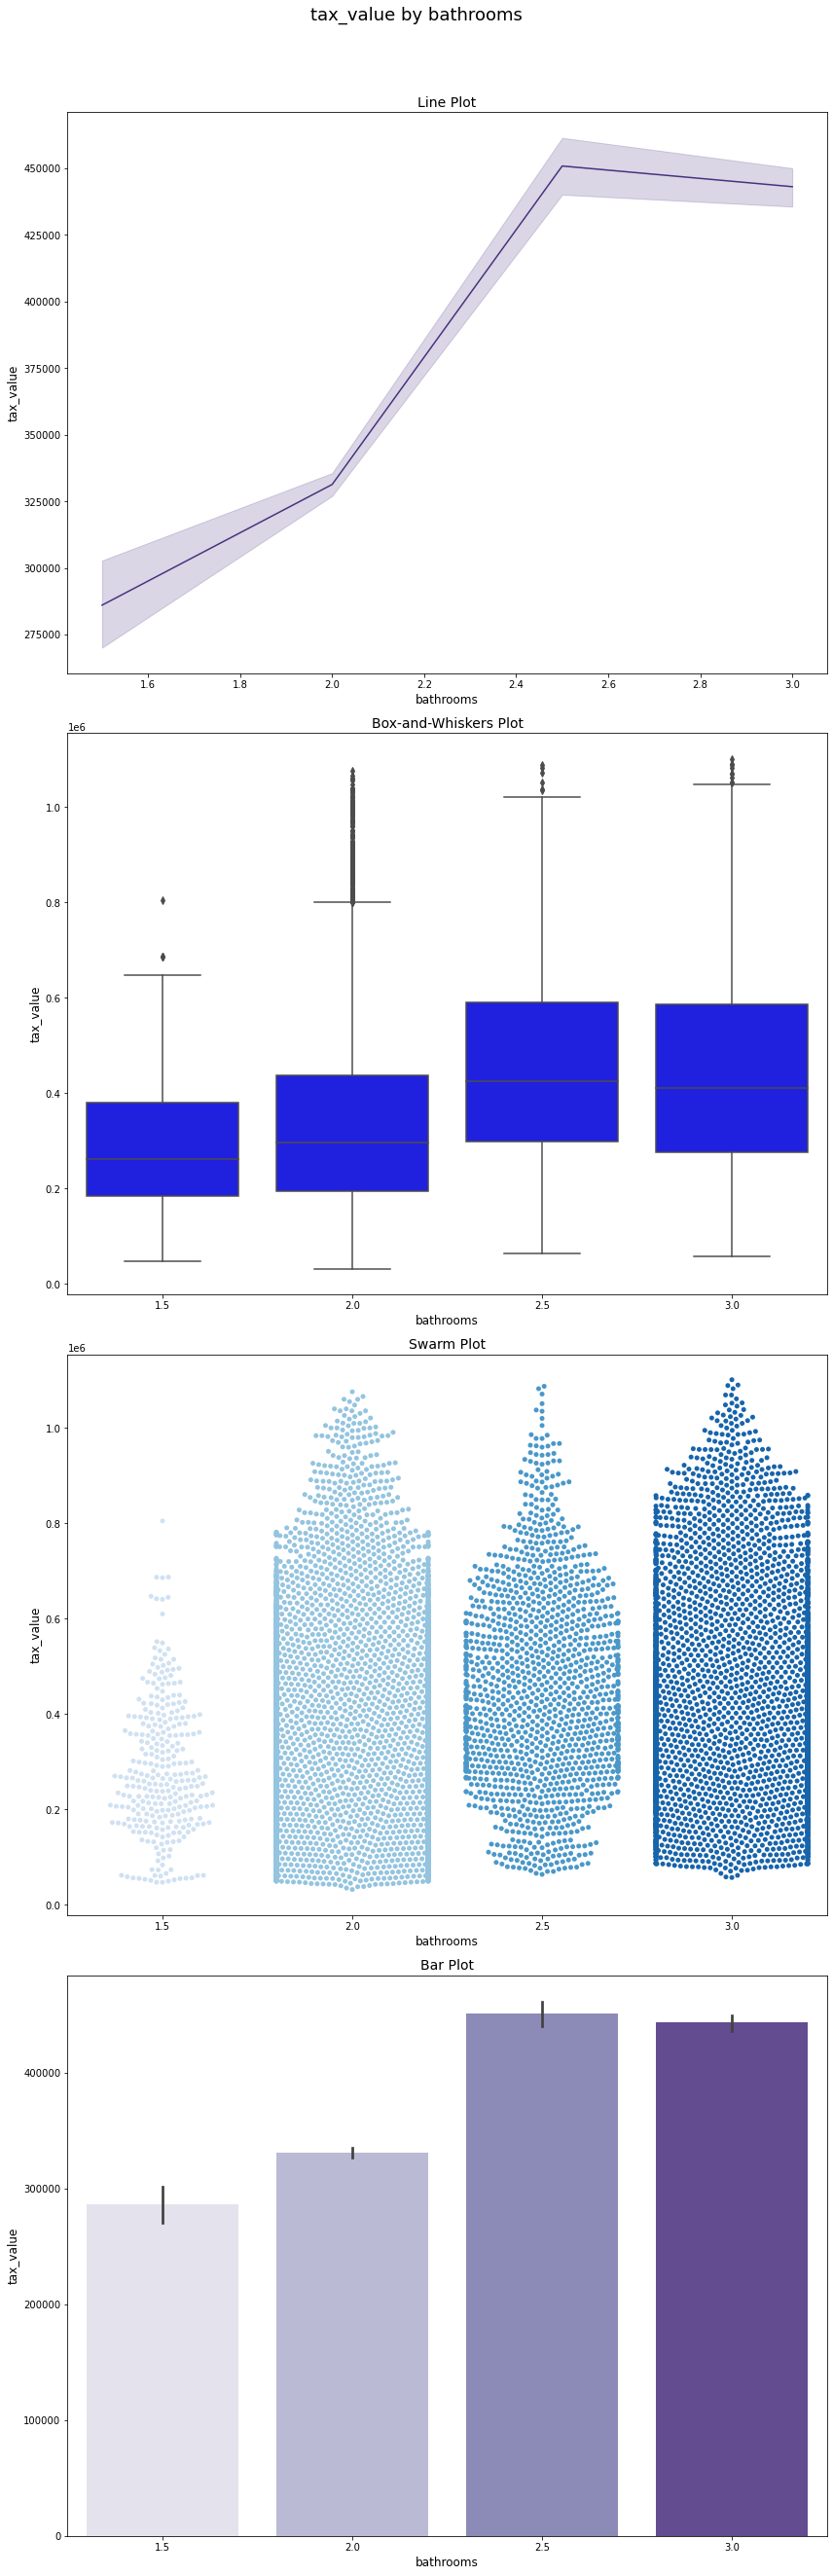

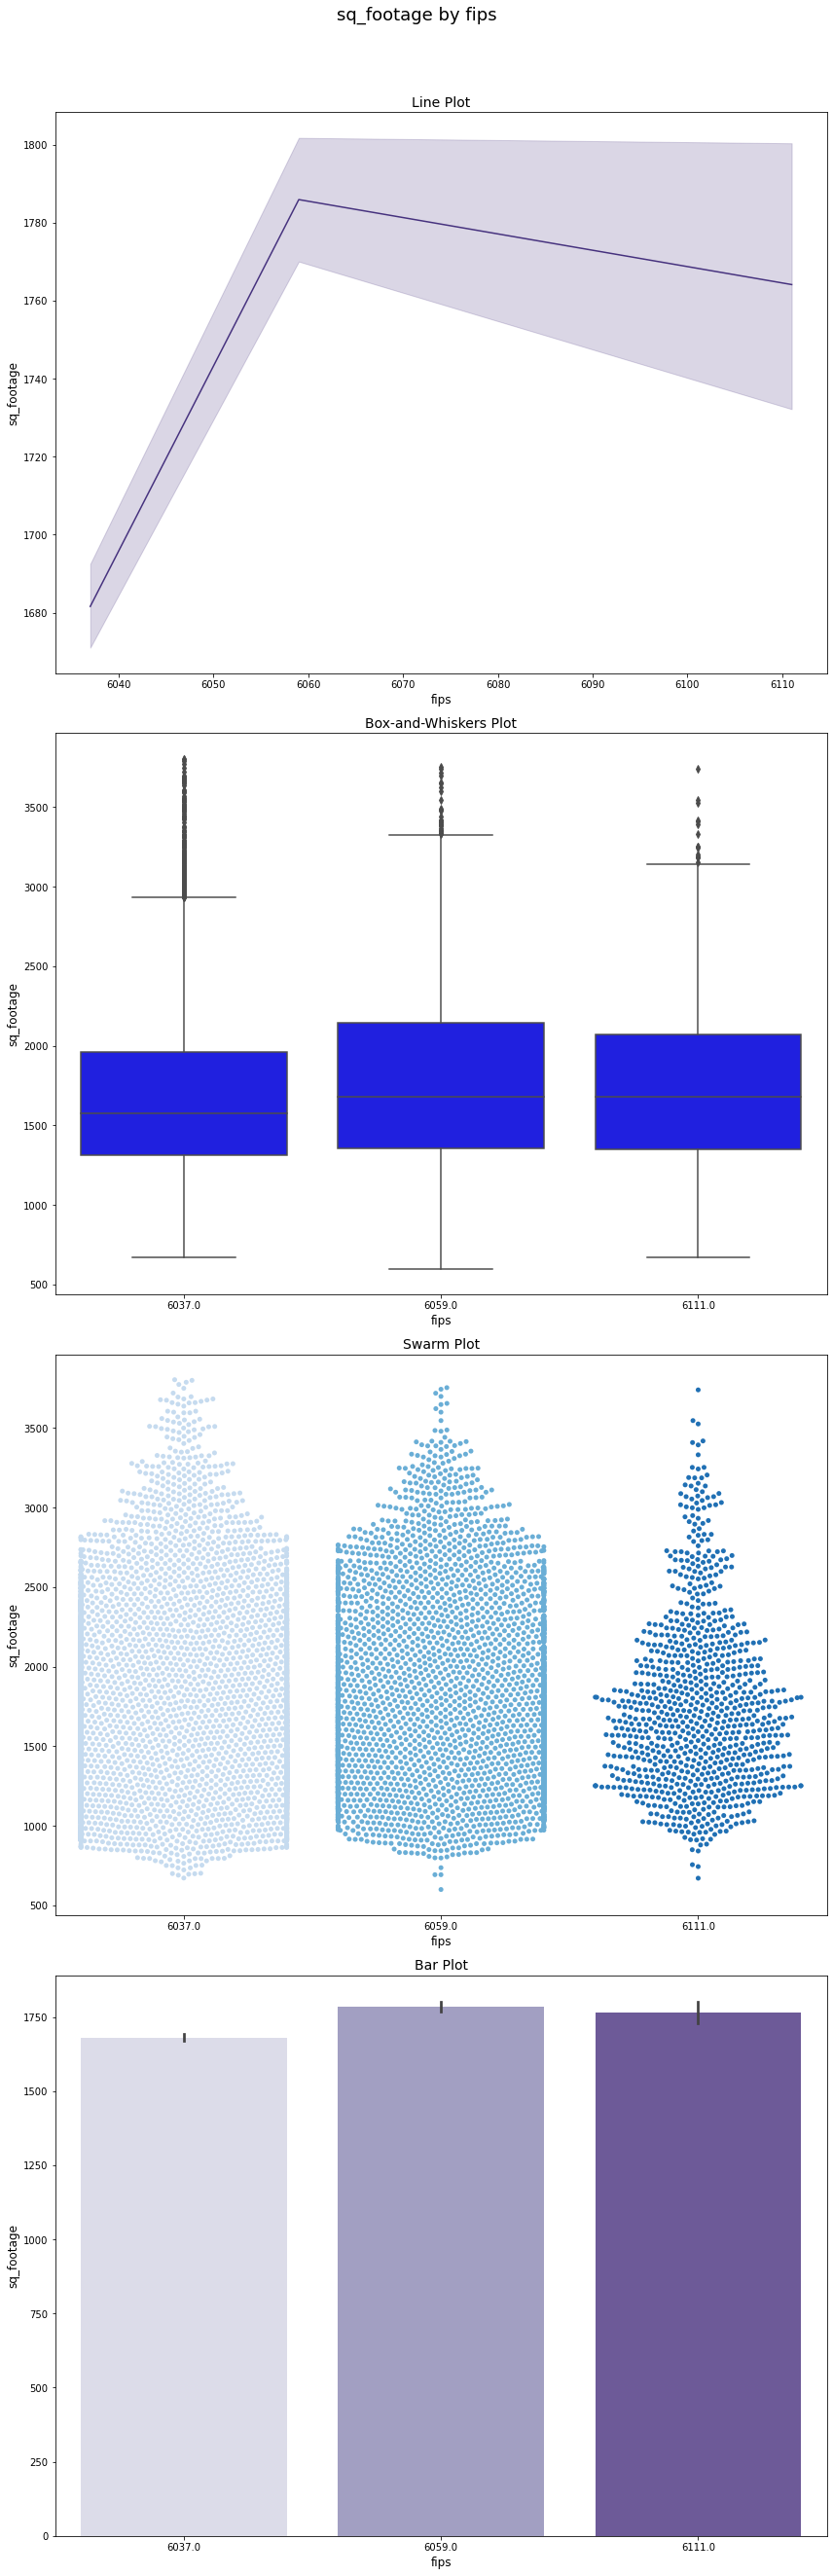

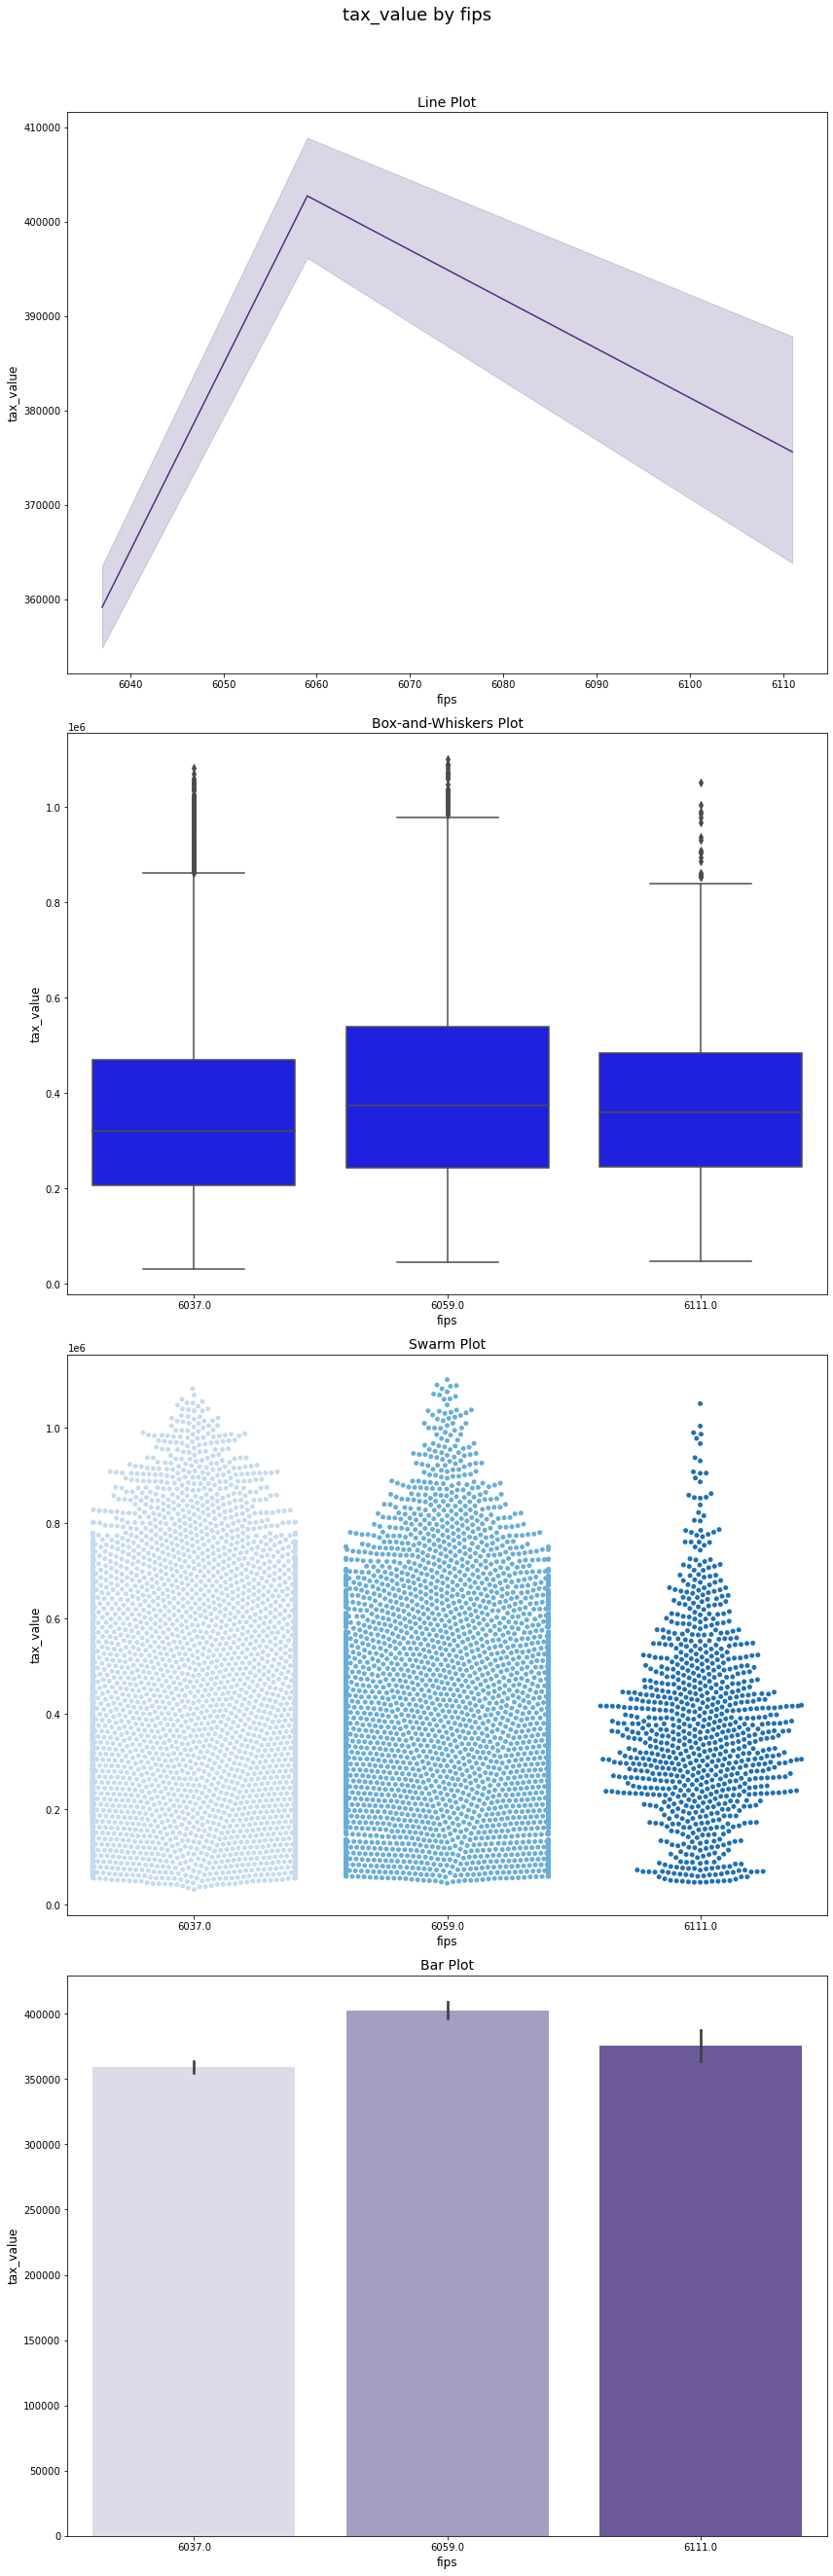

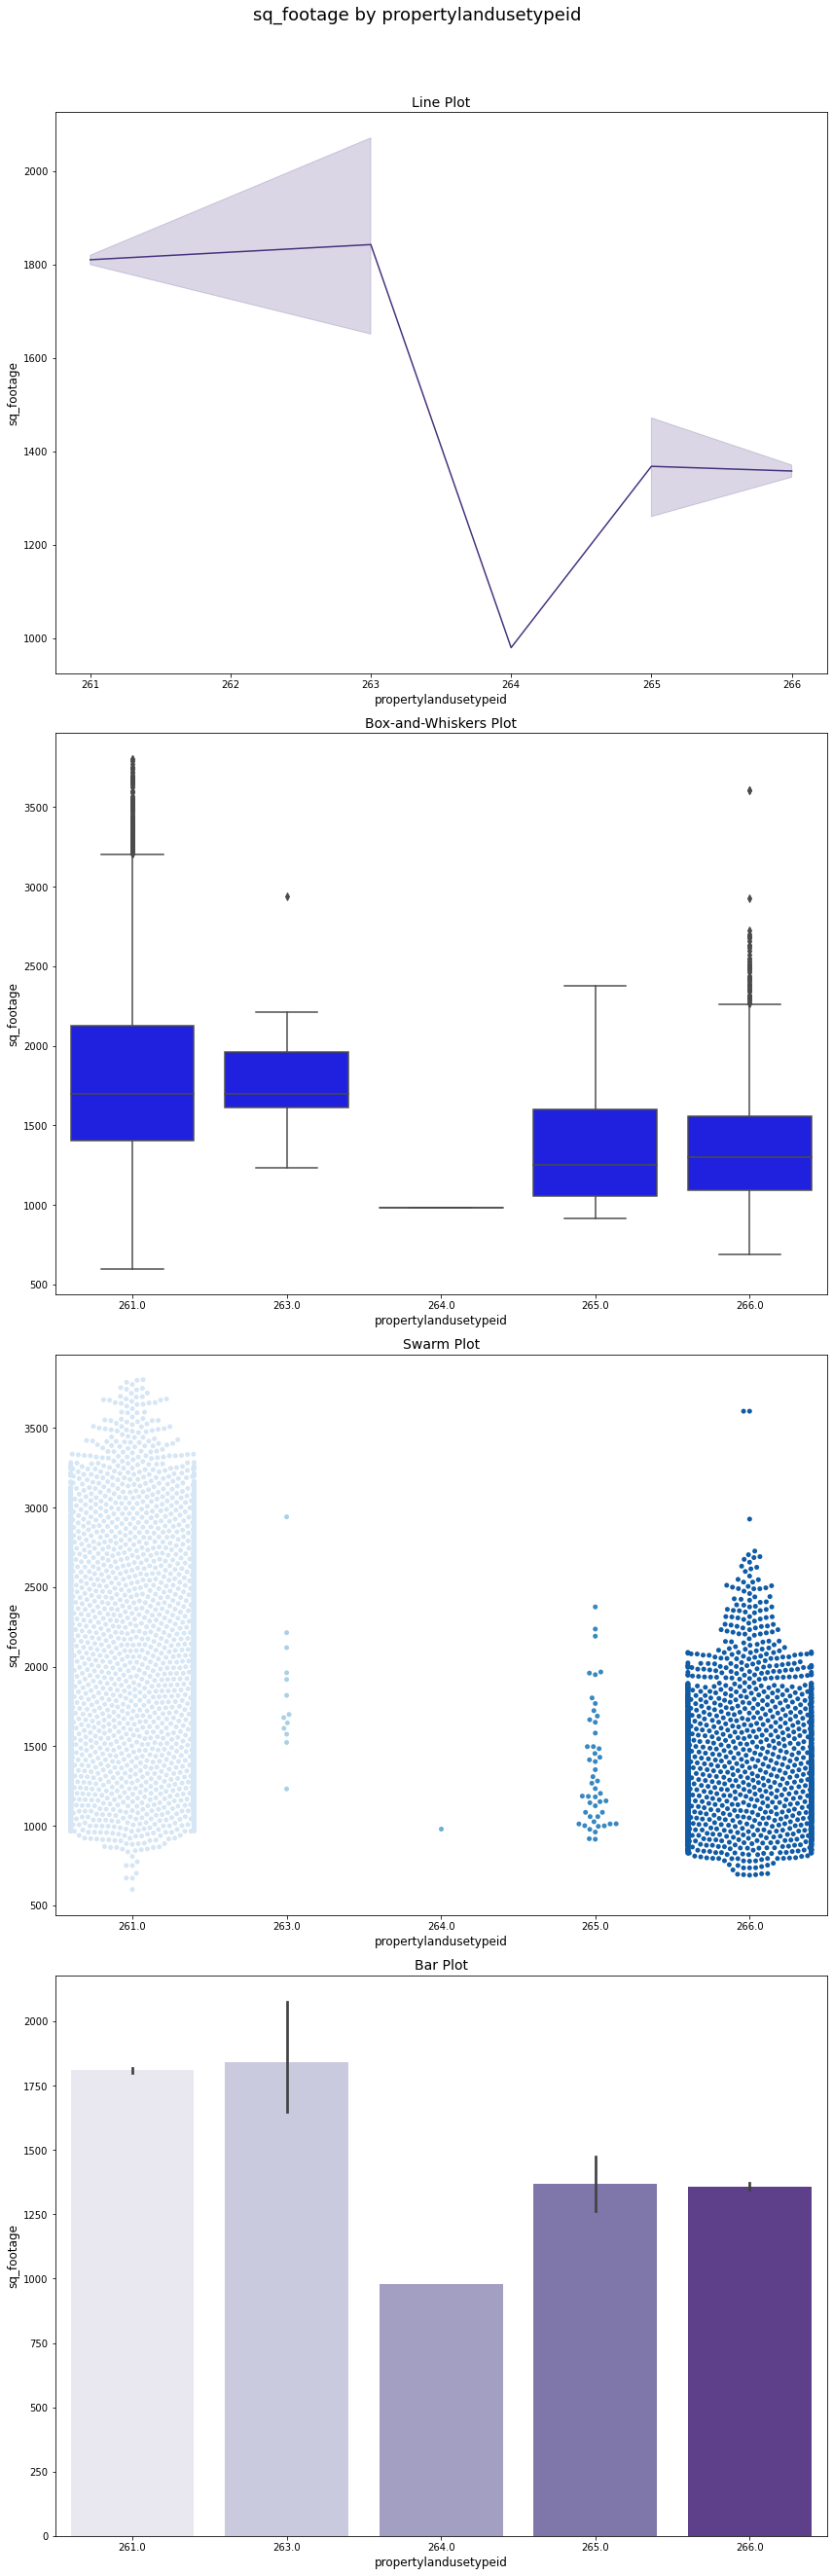

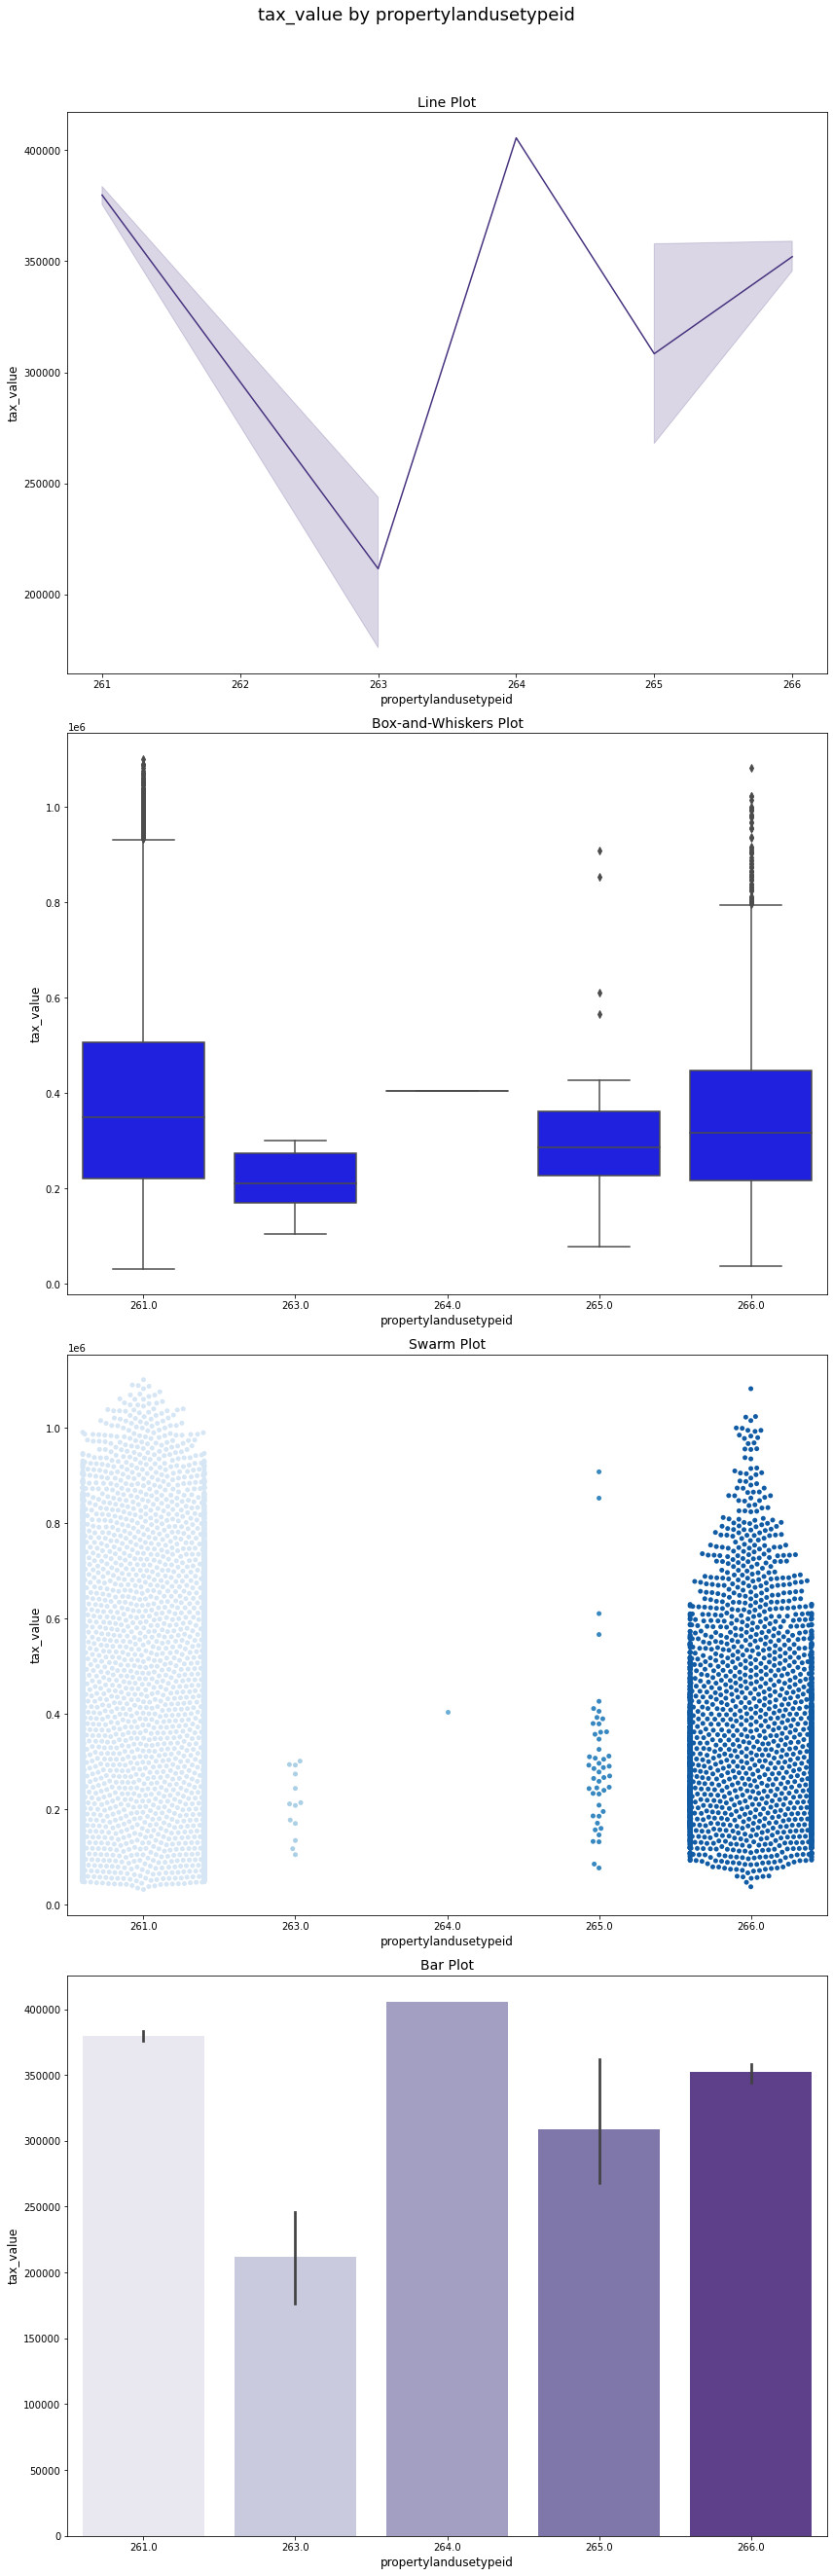

In [53]:
plot_categorical_and_continuous_vars(categorical_vars, continuous_vars, train, descriptive=None)

In [ ]:
import explore
explore.explore_univariate(train, categorical_vars, continuous_vars)

In [ ]:
cont_vars = ['sq_footage','taxamount','tax_value']
cat_vars = ['bathrooms', 'fips', 'yr_built']
explore.explore_bivariate(train, 'bedrooms', cat_vars, cont_vars)

# Hypotheses

### Visualize and Test

To test my hypothesis, I'm going to create some visualizations and test statistics with the Zillow data.
At the same time, I'll be checking that the key assumptions for multiple linear regression are met.

### Hypothesis Number One
##### Compute test statistic and probability (t-statistic & p-value)

$H_{0}$: Mean of price for single family residential  <= Mean of all single unit properties

$H_{a}$: Mean of price for single family residential > Mean of monthly charges of all customers

In [56]:
single_fam_property_mean = train[train.propertylandusetypeid==261].tax_value.mean()
single_fam_property_mean

379785.82033773186

In [57]:
#Set alpha
alpha = .05

In [58]:
all_single_units_price_mean = train.tax_value.mean()
all_single_units_price_mean

373946.52162042505

In [63]:
single_fam_property = train[train.propertylandusetypeid==261].tax_value

all_single_units_price = train.tax_value

In [67]:
t, p = stats.ttest_1samp(single_fam_property, all_single_units_price_mean)

print(t, p, p/2, alpha)

2.8546894798482043 0.004316069154118433 0.0021580345770592165 0.05


In [72]:
if p/2 > alpha:
    print("We fail to reject $H_{0}$, that Mean of price for single family residential <= Mean of all single unit properties")
elif t < 0:
    print("We fail to reject $H_{0}$, that Mean of price for single family residential <= Mean of all single unit properties")
else:
    print("We reject $H_{0}$, Mean of price for single family residential <= Mean of all single unit properties")

We reject $H_{0}$, Mean of price for single family residential <= Mean of all single unit properties


Text(0.5, 1.0, 'Single Family Homes Distribution')

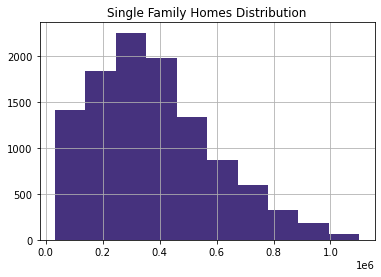

In [88]:
single_fam_property.hist()
plt.title("Single Family Homes Distribution")

Text(0.5, 1.0, 'All Single Unit Properties Distribution')

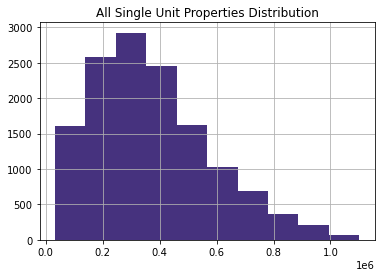

In [89]:
all_single_units_price.hist()
plt.title("All Single Unit Properties Distribution")

 ### Hypothesis Number Two
 $ Ho $
: Null Hypothesis: There is no correlation between the square footage and price.

$ H \alpha$ : Alternative Hypothesis: Square footage and price are correlated.

In [73]:
x = train.sq_footage
y = train.tax_value

In [74]:
corr, p = stats.pearsonr(x, y)
corr, p

(0.39868284969385087, 0.0)

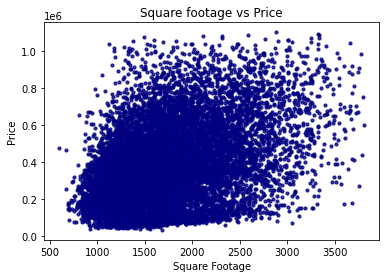

In [87]:
plt.scatter(x, y, s=10, c='navy', alpha=.8)
plt.title('Square footage vs Price')
plt.xlabel("Square Footage")
plt.ylabel("Price")
plt.yscale(value='linear')

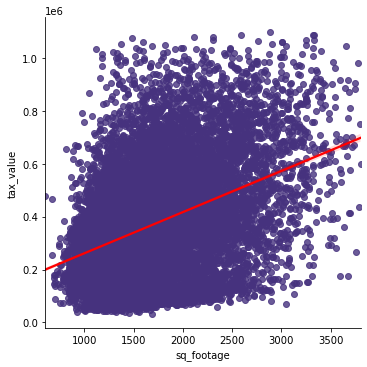

In [54]:
sns.lmplot(x="sq_footage", y="tax_value", data=train, line_kws={'color': 'red'})
plt.show()

 $ Ho $
: Null Hypothesis: There is no correlation between number of bedrooms and price.

$ H \alpha$ : Alternative Hypothesis: Number of bedrooms and price are correlated.

## Modeling

### Baseline

About the initial baseline: 

> Before we begin making models, we need to know how well we can estimate (predict) the final price (tax_value) without using any features. This is often done by predicting every observation's target value to be the mean or the median. E.g. we could predict every price to be the mean price of all the properties in our training sample. We will try both the mean and the median, see which performs best, and set that evaluation metric value as our baseline performance to beat. 


1. Predict all prices to be $363,845.89, which is equal to the mean of tax_value for the training sample. Store in `y_train['price_pred_mean']`. 

2. Predict all final grades to be $328,010.00, which is equal to the median of tax_value  for the training sample. Store in `y_train['price_pred_median']`.  

3. Compute the RMSE comparing actual final price (tax_value) to price_pred_mean. 

4. Compute the RMSE comparing actual final grade (tax_value) to price_pred_median. 

**Target Variable/y**

This helps us determine which type of algorithm we may want to use. 

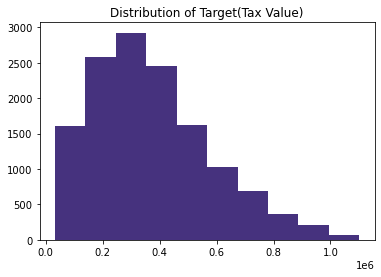

In [90]:
# how do we determine distribution?
plt.hist(y_train)
plt.title('Distribution of Target(Tax Value)')
plt.show()

In [91]:
len(y_train)

13552

In [92]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_train.head()

tax_value
4012    913000.0
5946    317407.0
27404   311000.0
34138   821084.0
14592   173450.0

In [93]:
y_validate.head()

tax_value
22515   310302.0
34969   468578.0
26129   348574.0
21368   272599.0
22471   169415.0

In [94]:
# 1. Predict price_pred_mean
price_pred_mean = y_train.tax_value.mean()
y_train['price_pred_mean'] = price_pred_mean
y_validate['price_pred_mean'] = price_pred_mean

In [95]:
round(price_pred_mean,2)

373946.52

In [96]:
# 2. compute price_pred_median
price_pred_median = y_train.tax_value.median()
y_train['price_pred_median'] = price_pred_median
y_validate['price_pred_median'] = price_pred_median

round(price_pred_median,2)

342420.5

In [99]:
# 3. RMSE of price_pred_mean
rmse_train = mean_squared_error(y_train.tax_value,
                                y_train.price_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.price_pred_mean) ** (1/2)

In [100]:
rmse_train_2 = mean_squared_error(y_train.tax_value,
                                y_train.price_pred_mean, squared = False)
rmse_validate_2 = mean_squared_error(y_validate.tax_value, y_validate.price_pred_mean, squared = False)

In [101]:
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  207116.99 
Validate/Out-of-Sample:  209911.46


In [102]:
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train_2, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_2, 2))

RMSE using Mean
Train/In-Sample:  207116.99 
Validate/Out-of-Sample:  209911.46


In [103]:
# 4. RMSE of price_pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.price_pred_median) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.price_pred_median) ** .5
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Median
Train/In-Sample:  209502.6 
Validate/Out-of-Sample:  211776.08



#### Addendum/Note:
we will incrementally build 
a dataframe for comparison of 
our metrics for model selection
for ease of reflection

In [104]:
def make_metric_df(y, y_pred, model_name, metric_df):
    if metric_df.size ==0:
        metric_df = pd.DataFrame(data=[
            {
                'model': model_name, 
                'RMSE_validate': mean_squared_error(
                    y,
                    y_pred) ** .5,
                'r^2_validate': explained_variance_score(
                    y,
                    y_pred)
            }])
        return metric_df
    else:
        return metric_df.append(
            {
                'model': model_name, 
                'RMSE_validate': mean_squared_error(
                    y,
                    y_pred) ** .5,
                'r^2_validate': explained_variance_score(
                    y,
                    y_pred)
            }, ignore_index=True)

In [105]:
# create the metric_df as a blank dataframe
metric_df = pd.DataFrame()
# make our first entry into the metric_df with median baseline
metric_df = make_metric_df(y_train.tax_value,
                           y_train.price_pred_median,
                           'median_baseline',
                          metric_df)

In [106]:
metric_df

model  RMSE_validate  r^2_validate
0  median_baseline  209502.599559           0.0

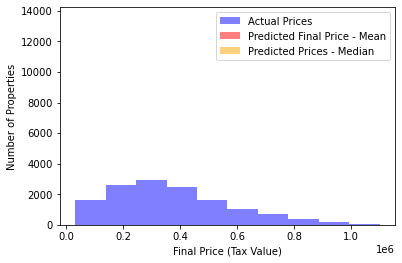

In [107]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.tax_value, color='blue', alpha=.5, label="Actual Prices")
plt.hist(y_train.price_pred_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted Final Price - Mean")
plt.hist(y_train.price_pred_median, bins=1, color='orange', alpha=.5, rwidth=100, label="Predicted Prices - Median")
plt.xlabel("Final Price (Tax Value)")
plt.ylabel("Number of Properties")
plt.legend()
plt.show()

### LinearRegression (OLS)

1. Fit the model using X_train_scaled and the labels from y_train. 

2. Predict final price for properties in training sample using our model (lm). 

3. Evaluate using RMSE

4. Repeat predictions and evaluation for validation. 

5. Compare RMSE train vs. validation. Overfitting? 

In [108]:
y_train.head()

tax_value  price_pred_mean  price_pred_median
4012    913000.0     373946.52162           342420.5
5946    317407.0     373946.52162           342420.5
27404   311000.0     373946.52162           342420.5
34138   821084.0     373946.52162           342420.5
14592   173450.0     373946.52162           342420.5

In [109]:
# create the model object
# 
# make the thing
# 
lm = LinearRegression(normalize=True)

In [110]:
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
# 
# fit the thing
# 
lm.fit(X_train, y_train.tax_value)

LinearRegression(normalize=True)

In [111]:
# predict train
# 
# use the thing!
# 
y_train['price_pred_lm'] = lm.predict(X_train)

In [112]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.price_pred_lm) ** (1/2)

# predict validate
y_validate['price_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.price_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  36123.880800210885 
Validation/Out-of-Sample:  36108.26689804799


In [113]:
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.price_pred_lm)}, ignore_index=True)

In [114]:
metric_df

model  RMSE_validate  r^2_validate
0  median_baseline  209502.599559      0.000000
1    OLS Regressor   36108.266898      0.970409

### LassoLars

1. Fit the model using X_train_scaled and the labels from y_train. 

2. Predict final grade for students in training sample using our model (lars). 

3. Evaluate using RMSE

4. Repeat predictions and evaluation for validation. 

5. Compare RMSE train vs. validation. Overfitting? 

In [115]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train, y_train.tax_value)

# predict train
y_train['price_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.price_pred_lars) ** (1/2)

# predict validate
y_validate['price_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.price_pred_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  36126.93774091429 
Validation/Out-of-Sample:  36117.85300506036


In [116]:
metric_df = make_metric_df(y_validate.tax_value,
               y_validate.price_pred_lars,
               'lasso_alpha_1',
               metric_df)

In [117]:
metric_df

model  RMSE_validate  r^2_validate
0  median_baseline  209502.599559      0.000000
1    OLS Regressor   36108.266898      0.970409
2    lasso_alpha_1   36117.853005      0.970393

### Trying a higher alpha translates into a higher RMSE. Sticking with alpha = 1 for lower RMSE.

In [118]:
# create the model object
lars = LassoLars(alpha=4)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train, y_train.tax_value)

# predict train
y_train['price_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.price_pred_lars) ** (1/2)

# predict validate
y_validate['price_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.price_pred_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  36170.84151572355 
Validation/Out-of-Sample:  36179.37121734128


### TweedieRegressor (GLM)

1. Fit the model using X_train_scaled and the labels from y_train. 

2. Predict final price for properties in training sample using our model (glm). 

3. Evaluate using RMSE

4. Repeat predictions and evaluation for validation. 

5. Compare RMSE train vs. validation. Overfitting? 

In [119]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.tax_value)

# predict train
y_train['price_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.price_pred_glm) ** (1/2)

# predict validate
y_validate['price_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.price_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  76432.32301812236 
Validation/Out-of-Sample:  77769.3427455946


In [120]:
make_metric_df(y_validate.tax_value,
               y_validate.price_pred_glm,
               'glm_poisson',
               metric_df)

model  RMSE_validate  r^2_validate
0  median_baseline  209502.599559      0.000000
1    OLS Regressor   36108.266898      0.970409
2    lasso_alpha_1   36117.853005      0.970393
3      glm_poisson   77769.342746      0.862833

In [121]:
### Using a different power to try the fit to a different distribution

In [122]:
# create the model object
glm = TweedieRegressor(power=0, alpha=0)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.tax_value)

# predict train
y_train['price_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.price_pred_glm) ** (1/2)

# predict validate
y_validate['price_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.price_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=0 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=0 & alpha=0
Training/In-Sample:  36123.880800210914 
Validation/Out-of-Sample:  36108.26682823993


### Polynomial Regression

Using sklearn.preprocessing.PolynommialFeatures() + sklearn.linear_model.LinearRegression()

1. Create the new features, based on value indicated for degree for train, validate & test. 

2. Fit the Linear Regression model

3. Predict using the transformed (squared or cubed, e.g.) features 

4. Evaluate using RMSE

5. Repeat predictions and evaluation for validation.

6. Compare RMSE train vs. validation. Overfitting?

## **PolynomialFeatures**

In [123]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 =  pf.transform(X_test)

## **LinearRegression**

In [124]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['price_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.price_pred_lm2) ** (1/2)

# predict validate
y_validate['price_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.price_pred_lm2) ** 0.5

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  33430.368877557936 
Validation/Out-of-Sample:  33633.434143461986


In [125]:
metric_df = make_metric_df(y_validate.tax_value,
               y_validate.price_pred_lm2,
               'quadratic',
               metric_df)

In [126]:
metric_df

model  RMSE_validate  r^2_validate
0  median_baseline  209502.599559      0.000000
1    OLS Regressor   36108.266898      0.970409
2    lasso_alpha_1   36117.853005      0.970393
3        quadratic   33633.434143      0.974327

### Evaluate

**Plotting Actual vs. Predicted Values**

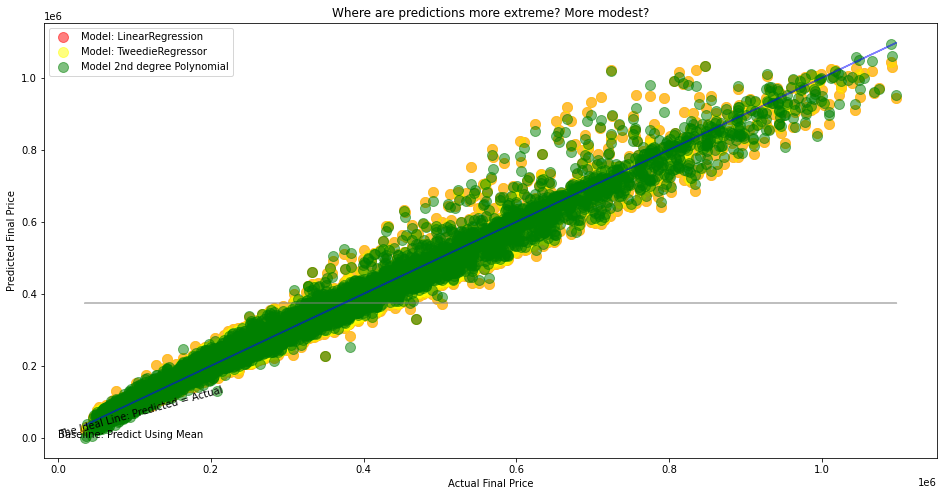

In [127]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.price_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.tax_value, y_validate.price_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.price_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.price_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Final Price")
plt.ylabel("Predicted Final Price")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

**Residual Plots: Plotting the Errors in Predictions**

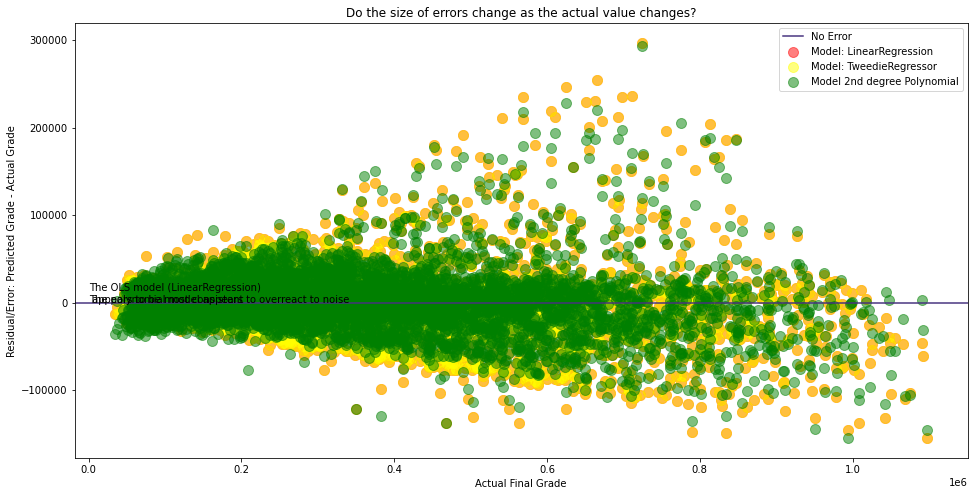

In [128]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.tax_value, y_validate.price_pred_lm - y_validate.tax_value , 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.price_pred_glm - y_validate.tax_value, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.price_pred_lm2 - y_validate.tax_value, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Final Grade")
plt.ylabel("Residual/Error: Predicted Grade - Actual Grade")
plt.title("Do the size of errors change as the actual value changes?")
plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

**Histograms**

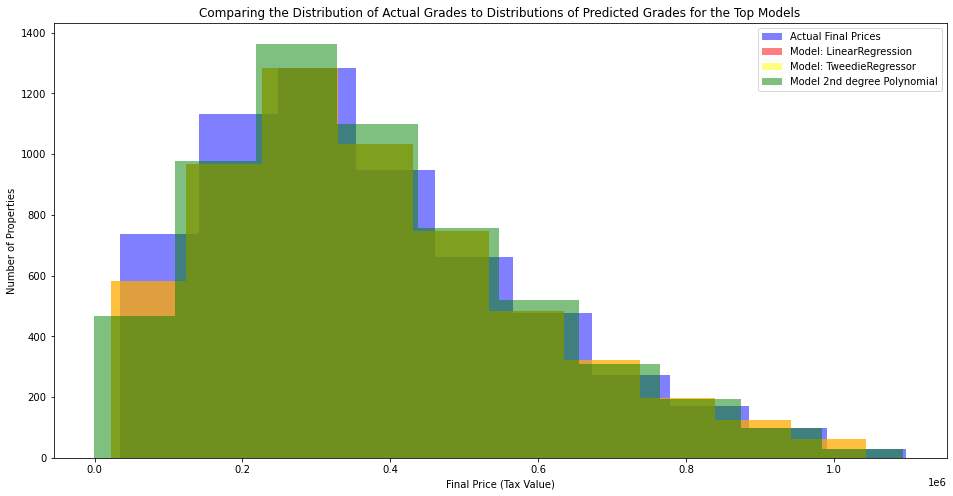

In [129]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.tax_value, color='blue', alpha=.5, label="Actual Final Prices")
plt.hist(y_validate.price_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.price_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.price_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Final Price (Tax Value)")
plt.ylabel("Number of Properties")
plt.title("Comparing the Distribution of Actual Grades to Distributions of Predicted Grades for the Top Models")
plt.legend()
plt.show()

In [130]:
# Comparing models DF:

In [131]:
metric_df

model  RMSE_validate  r^2_validate
0  median_baseline  209502.599559      0.000000
1    OLS Regressor   36108.266898      0.970409
2    lasso_alpha_1   36117.853005      0.970393
3        quadratic   33633.434143      0.974327

**Model Selection & Out-of-Sample Evaluation**

Model selected: lm (using LinearRegression)

In [ ]:
#y_test = pd.DataFrame(y_test)

# predict on test
#y_test['price_pred_lm'] = lm.predict(X_test)

# evaluate: rmse
#rmse_test = mean_squared_error(y_test.tax_value, y_test.price_pred_lm) ** (1/2)

#print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)